# Feature Engineering

To study whether volatility affect the strategy performance.

1) Spread between moving averages

2) ATR(Average True Range)

In [1]:
import pandas as pd
import numpy as np

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("C:/Users/USER/Documents/QQQ Project/data/processed/full_QQQ_data.csv")

# clean and prepare Date
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])
df = df.set_index('Date').sort_index()
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype('float64')
# --- Compute MA columns ---
df['MA20'] = df['Close'].rolling(20).mean()
df['MA50'] = df['Close'].rolling(50).mean()
df['MA100'] = df['Close'].rolling(100).mean()
df['MA200'] = df['Close'].rolling(200).mean()

# --- TrendAligned ---
df['TrendAligned'] = (
    (df['MA20'] > df['MA50']) &
    (df['MA50'] > df['MA100']) &
    (df['MA100'] > df['MA200'])
)
# --- Compute ATR(14) ---

# True Range components
df['H-L']  = df['High'] - df['Low']
df['H-PC'] = (df['High'] - df['Close'].shift(1)).abs()
df['L-PC'] = (df['Low']  - df['Close'].shift(1)).abs()

# True Range
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)

# ATR(14)
df['ATR14'] = df['TR'].rolling(14).mean()

# clean up
df = df.drop(columns=['H-L','H-PC','L-PC','TR'])

print(df.tail())
print(df.columns)


                  Open        High         Low       Close      Volume  \
Date                                                                     
2025-11-05  618.489990  626.599976  617.210022  623.280029  48688500.0   
2025-11-06  621.789978  622.039978  610.299988  611.669983  72115100.0   
2025-11-07  608.309998  609.950012  598.669983  609.739990  81835400.0   
2025-11-10  618.919983  624.309998  616.890015  623.229980  55919900.0   
2025-11-11  620.570007  622.719971  617.520020  621.570007  44685100.0   

                  MA20        MA50       MA100       MA200  TrendAligned  \
Date                                                                       
2025-11-05  614.447501  599.694446  579.046081  537.615570          True   
2025-11-06  614.495999  600.471327  579.832054  538.026373          True   
2025-11-07  615.507999  601.137891  580.650709  538.421898          True   
2025-11-10  616.568997  602.207699  581.605162  538.899865          True   
2025-11-11  617.747498  6

In [3]:
df.to_csv("C:/Users/USER/Documents/QQQ Project/data/processed/signal_data.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6712 entries, 1999-03-10 to 2025-11-11
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          6712 non-null   float64
 1   High          6712 non-null   float64
 2   Low           6712 non-null   float64
 3   Close         6712 non-null   float64
 4   Volume        6712 non-null   float64
 5   MA20          6693 non-null   float64
 6   MA50          6663 non-null   float64
 7   MA100         6613 non-null   float64
 8   MA200         6513 non-null   float64
 9   TrendAligned  6712 non-null   bool   
 10  ATR14         6699 non-null   float64
dtypes: bool(1), float64(10)
memory usage: 583.4 KB


In [5]:
TP = 0.07
SLIPPAGE = 0.0005

df_ml = df.loc[df.index >= df.index.max() - pd.Timedelta(days=10*365)].copy()
df_ml = df_ml.sort_index()

ml_rows = []

for i in range(len(df_ml)-1):

    today = df_ml.iloc[i]

    # Entry signal
    if (today['Close'] < today['MA20']) and today['TrendAligned']:
        
        entry_idx = i + 1
        if entry_idx >= len(df_ml):
            break

        entry_row = df_ml.iloc[entry_idx]
        entry_date = df_ml.index[entry_idx]
        entry_price = entry_row['Open'] * (1 + SLIPPAGE)

        phase = 'LOW_PHASE'
        exit_price = None
        exit_reason = None
        exit_date = None

        j = entry_idx

        while j < len(df_ml):
            row = df_ml.iloc[j]
            cur_date = df_ml.index[j]

            # Stop-loss
            if row['Low'] <= row['MA50']:
                exit_price = row['MA50'] * (1 - SLIPPAGE)
                exit_reason = 'SL'
                exit_date = cur_date
                break

            # Take-profit
            tp_price = entry_price * (1 + TP)
            if row['High'] >= tp_price:
                exit_price = tp_price * (1 - SLIPPAGE)
                exit_reason = 'TP'
                exit_date = cur_date
                break

            # Phase switching
            if (phase == 'LOW_PHASE' and row['Close'] > row['MA20']):
                phase = 'HIGH_PHASE'

            elif (phase == 'HIGH_PHASE' and row['Close'] < row['MA20']):
                exit_price = row['Close'] * (1 - SLIPPAGE)
                exit_reason = 'Close<MA20'
                exit_date = cur_date
                break

            j += 1

        # If never exited (rare)
        if exit_price is None:
            last = df_ml.iloc[-1]
            exit_price = last['Close']
            exit_reason = 'EOD'
            exit_date = df_ml.index[-1]

        # Label
        label = 1 if exit_reason == 'TP' else 0

        ml_rows.append({
            'entry_date': entry_date,
            'entry_price': entry_price,
            'exit_date': exit_date,
            'exit_price': exit_price,
            'exit_reason': exit_reason,
            'TP_hit': label
        })

ml_df = pd.DataFrame(ml_rows)
print("ML samples:", len(ml_df))
ml_df.head()


ML samples: 365


,entry_date,entry_price,exit_date,exit_price,exit_reason,TP_hit
0,2015-12-04,112.906423,2015-12-09,105.474710,Close<MA20,0
1,2015-12-10,113.206577,2015-12-17,104.942162,Close<MA20,0
2,2015-12-11,112.146041,2015-12-17,104.942162,Close<MA20,0
3,2015-12-14,110.995472,2015-12-17,104.942162,Close<MA20,0
4,2015-12-15,112.716334,2015-12-17,104.942162,Close<MA20,0


In [6]:
print(df_ml.columns)
print(df_ml.dtypes)


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'MA20', 'MA50', 'MA100',
       'MA200', 'TrendAligned', 'ATR14'],
      dtype='object')
Open            float64
High            float64
Low             float64
Close           float64
Volume          float64
MA20            float64
MA50            float64
MA100           float64
MA200           float64
TrendAligned       bool
ATR14           float64
dtype: object


In [7]:
features = []

for idx, row in ml_df.iterrows():
    date = row['entry_date']
    bar = df_ml.loc[date]

    feats = {
        'entry_date': row['entry_date'],
        'TP_hit': row['TP_hit'],

        # MA spreads
        'MA20_MA50': bar['MA20'] - bar['MA50'],
        'MA20_MA100': bar['MA20'] - bar['MA100'],
        'MA20_MA200': bar['MA20'] - bar['MA200'],
        'MA50_MA100': bar['MA50'] - bar['MA100'],
        'MA100_MA200': bar['MA100'] - bar['MA200'],

        # Normalized spreads
        'MA20_MA50_norm': (bar['MA20'] - bar['MA50']) / bar['MA50'],
        'MA20_MA200_norm': (bar['MA20'] - bar['MA200']) / bar['MA200'],

        # Price relative to MA
        'Close_MA20': bar['Close']/bar['MA20'] - 1,
        'Close_MA50': bar['Close']/bar['MA50'] - 1,
        'Close_MA200': bar['Close']/bar['MA200'] - 1,

        # Volatility (ATR): must exist in df
        'ATR14': bar['ATR14'],
        'ATR_ratio': bar['ATR14'] / bar['Close'],

        # Pullback depth
        'pullback_depth': (bar['MA20'] - bar['Close']) / bar['Close'],

        # Recent returns
        'ret_1d': df_ml['Close'].pct_change().loc[date],
        'ret_3d': df_ml['Close'].pct_change(3).loc[date],
        'ret_5d': df_ml['Close'].pct_change(5).loc[date],

        # Candle size
        'HL_range': (bar['High'] - bar['Low']) / bar['Close']
    }

    features.append(feats)

dataset = pd.DataFrame(features)
dataset = dataset.dropna()
print(dataset.shape)
dataset.head()


(365, 19)


,entry_date,TP_hit,MA20_MA50,MA20_MA100,MA20_MA200,MA50_MA100,MA100_MA200,MA20_MA50_norm,MA20_MA200_norm,Close_MA20,Close_MA50,Close_MA200,ATR14,ATR_ratio,pullback_depth,ret_1d,ret_3d,ret_5d,HL_range
0,2015-12-04,0,2.933438,4.212639,4.763550,1.279202,0.550911,0.028443,0.047023,0.014749,0.043612,0.062465,8.316843,0.077272,-0.014535,0.023376,-0.000174,0.007261,0.025179
1,2015-12-10,0,2.008004,4.218057,4.685729,2.210054,0.467671,0.019290,0.046203,-0.000921,0.018352,0.045240,8.125476,0.076652,0.000922,0.004518,-0.010644,0.007910,0.012735
2,2015-12-11,0,1.789359,4.174187,4.612589,2.384827,0.438402,0.017163,0.045475,-0.023377,-0.006615,0.021035,7.990462,0.077154,0.023937,-0.023016,-0.033499,-0.037780,0.016125
3,2015-12-14,0,1.730561,4.260631,4.682156,2.530071,0.421525,0.016577,0.046155,-0.016749,-0.000450,0.028633,8.003985,0.076704,0.017034,0.007581,-0.011161,-0.026087,0.022041
4,2015-12-15,0,1.644842,4.288399,4.704115,2.643556,0.415716,0.015737,0.046362,-0.011147,0.004414,0.034699,8.097958,0.077134,0.011272,0.006092,-0.009612,-0.020239,0.010573


# Point-Biserial Correlation

In [8]:
from scipy.stats import pointbiserialr
import pandas as pd

corrs = {}

for col in dataset.columns:
    if col == "TP_hit":
        continue
    r, p = pointbiserialr(dataset['TP_hit'], dataset[col])
    corrs[col] = r

corr_df = pd.DataFrame.from_dict(corrs, orient='index', columns=['Correlation'])
corr_df = corr_df.sort_values('Correlation', ascending=False)
corr_df


,Correlation
Close_MA50,0.254891
Close_MA20,0.222071
ret_3d,0.213483
ret_5d,0.197430
ret_1d,0.156245
MA20_MA50_norm,0.153673
MA20_MA50,0.079325
Close_MA200,0.059169
entry_date,0.012132
MA20_MA100,-0.010464


# Mutual Information 

In [10]:
from sklearn.feature_selection import mutual_info_classif

X = dataset.drop(columns=['TP_hit','entry_date'])
y = dataset['TP_hit']

mi = mutual_info_classif(X, y, discrete_features=False, random_state=42)

mi_df = pd.DataFrame({'Feature': X.columns, 'MI': mi})
mi_df = mi_df.sort_values('MI', ascending=False)
mi_df


,Feature,MI
4,MA100_MA200,0.072959
11,ATR_ratio,0.063033
3,MA50_MA100,0.053429
10,ATR14,0.052980
1,MA20_MA100,0.051931
8,Close_MA50,0.045637
6,MA20_MA200_norm,0.039833
7,Close_MA20,0.032883
12,pullback_depth,0.032811
2,MA20_MA200,0.024732


# Results

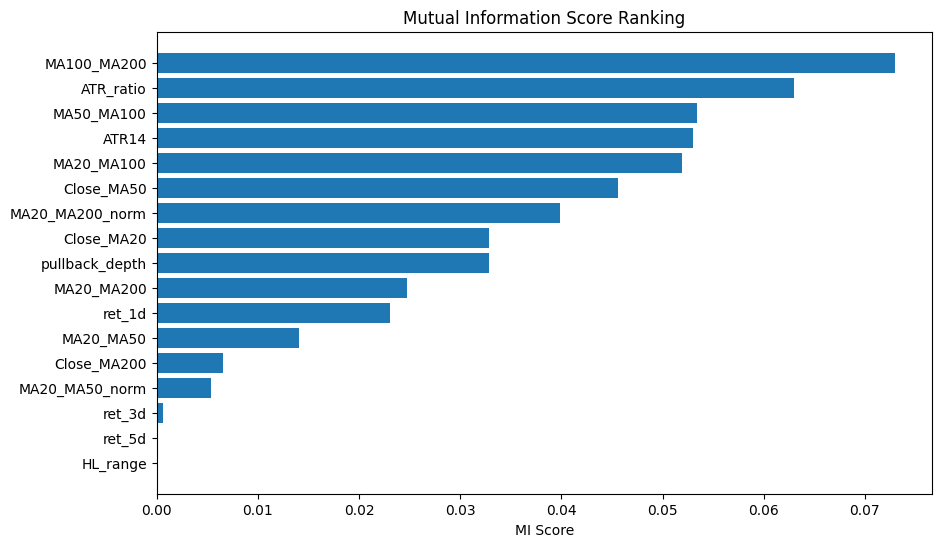

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(mi_df['Feature'], mi_df['MI'])
plt.title("Mutual Information Score Ranking")
plt.xlabel("MI Score")
plt.gca().invert_yaxis()
plt.show()


Drop MA20_MA50_norm,
Close_MA200,
MA20_MA200,
ret_1d,
ret_3d,
ret_5d,
HL_range

In [13]:
selected_features = [
    'entry_date',
    'MA100_MA200',
    'ATR_ratio',
    'MA50_MA100',
    'ATR14',
    'MA20_MA100',
    'Close_MA50',
    'MA20_MA200_norm',
    'Close_MA20',
    'pullback_depth',
    'MA20_MA50'
]
final_dataset = dataset[['TP_hit']+ selected_features]

In [14]:
final_dataset.to_csv(
    "C:/Users/USER/Documents/QQQ Project/data/processed/final_dataset.csv",
    index=False
)
